<a href="https://colab.research.google.com/github/SiddhantKadwe/TechLab/blob/Maroof/Driver_Drowsiness_Maroof_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.utils import load_img
import re

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -uq "/content/drive/MyDrive/Driver_Drowsiness/Driver_Drowsiness_Dataset.zip"

Mounted at /content/drive


In [4]:
input_path, label, file_name, person_ID = [], [], [], []

pattern = re.compile(r'^[a-zA-Z][a-zA-Z]?') #identification criteria of participant

for class_name in os.listdir("Driver Drowsiness Dataset (DDD)"):  #goes through all folders in DDD folder
  for path in os.listdir("Driver Drowsiness Dataset (DDD)/"+class_name):  #goes through all files in both folders and updates file path and labels
    if class_name == 'Drowsy':
      label.append(0)
    else:
      label.append(1)
    input_path.append(os.path.join("Driver Drowsiness Dataset (DDD)", class_name, path))
    file_name.append(path)

    person_ID.append(pattern.findall(path)[0])  #identification of participant

print(input_path[0], label[0], file_name[0], person_ID[0])

Driver Drowsiness Dataset (DDD)/Non Drowsy/x0242.png 1 x0242.png x


In [5]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df['name'] = file_name
df['person'] = person_ID
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

images  label        name person
0  Driver Drowsiness Dataset (DDD)/Non Drowsy/zb0...      1  zb0323.png     zb
1  Driver Drowsiness Dataset (DDD)/Non Drowsy/y10...      1   y1094.png      y
2  Driver Drowsiness Dataset (DDD)/Non Drowsy/k01...      1   k0115.png      k
3  Driver Drowsiness Dataset (DDD)/Non Drowsy/y05...      1   y0586.png      y
4  Driver Drowsiness Dataset (DDD)/Non Drowsy/b01...      1   b0169.png      b
5  Driver Drowsiness Dataset (DDD)/Drowsy/ZC0701.png      0  ZC0701.png     ZC
6  Driver Drowsiness Dataset (DDD)/Non Drowsy/a07...      1   a0740.png      a
7  Driver Drowsiness Dataset (DDD)/Non Drowsy/zc0...      1  zc0435.png     zc
8  Driver Drowsiness Dataset (DDD)/Non Drowsy/r03...      1   r0337.png      r
9   Driver Drowsiness Dataset (DDD)/Drowsy/V0503.png      0   V0503.png      V

In [6]:
df.groupby('label').size()

label
0    22348
1    19445
dtype: int64

In [7]:
df.groupby('person').size()

person
A     1411
B      315
C      335
D      179
E      962
F      415
G      499
H      508
I     1095
J      474
K      630
L      732
M      777
N     1156
O     1097
P      963
Q      562
R      204
S      487
T      933
U      420
V      653
W     1162
X     1749
Y     1112
ZA     621
ZB    1551
ZC    1346
a     1252
b      409
c      400
d     1005
e     1000
g      109
h      571
i     1045
j      717
k      538
l      381
m      473
n      957
o      671
p      190
q      521
r      522
s      457
u      510
v     1002
w      493
x     1143
y     1500
za    1054
zb    1237
zc    1288
dtype: int64

In [8]:
temp = df.loc[:,'images']
temp1 = temp[0]
#load_img(temp[0])
print(np.array(load_img(temp[0])).shape)

(227, 227, 3)


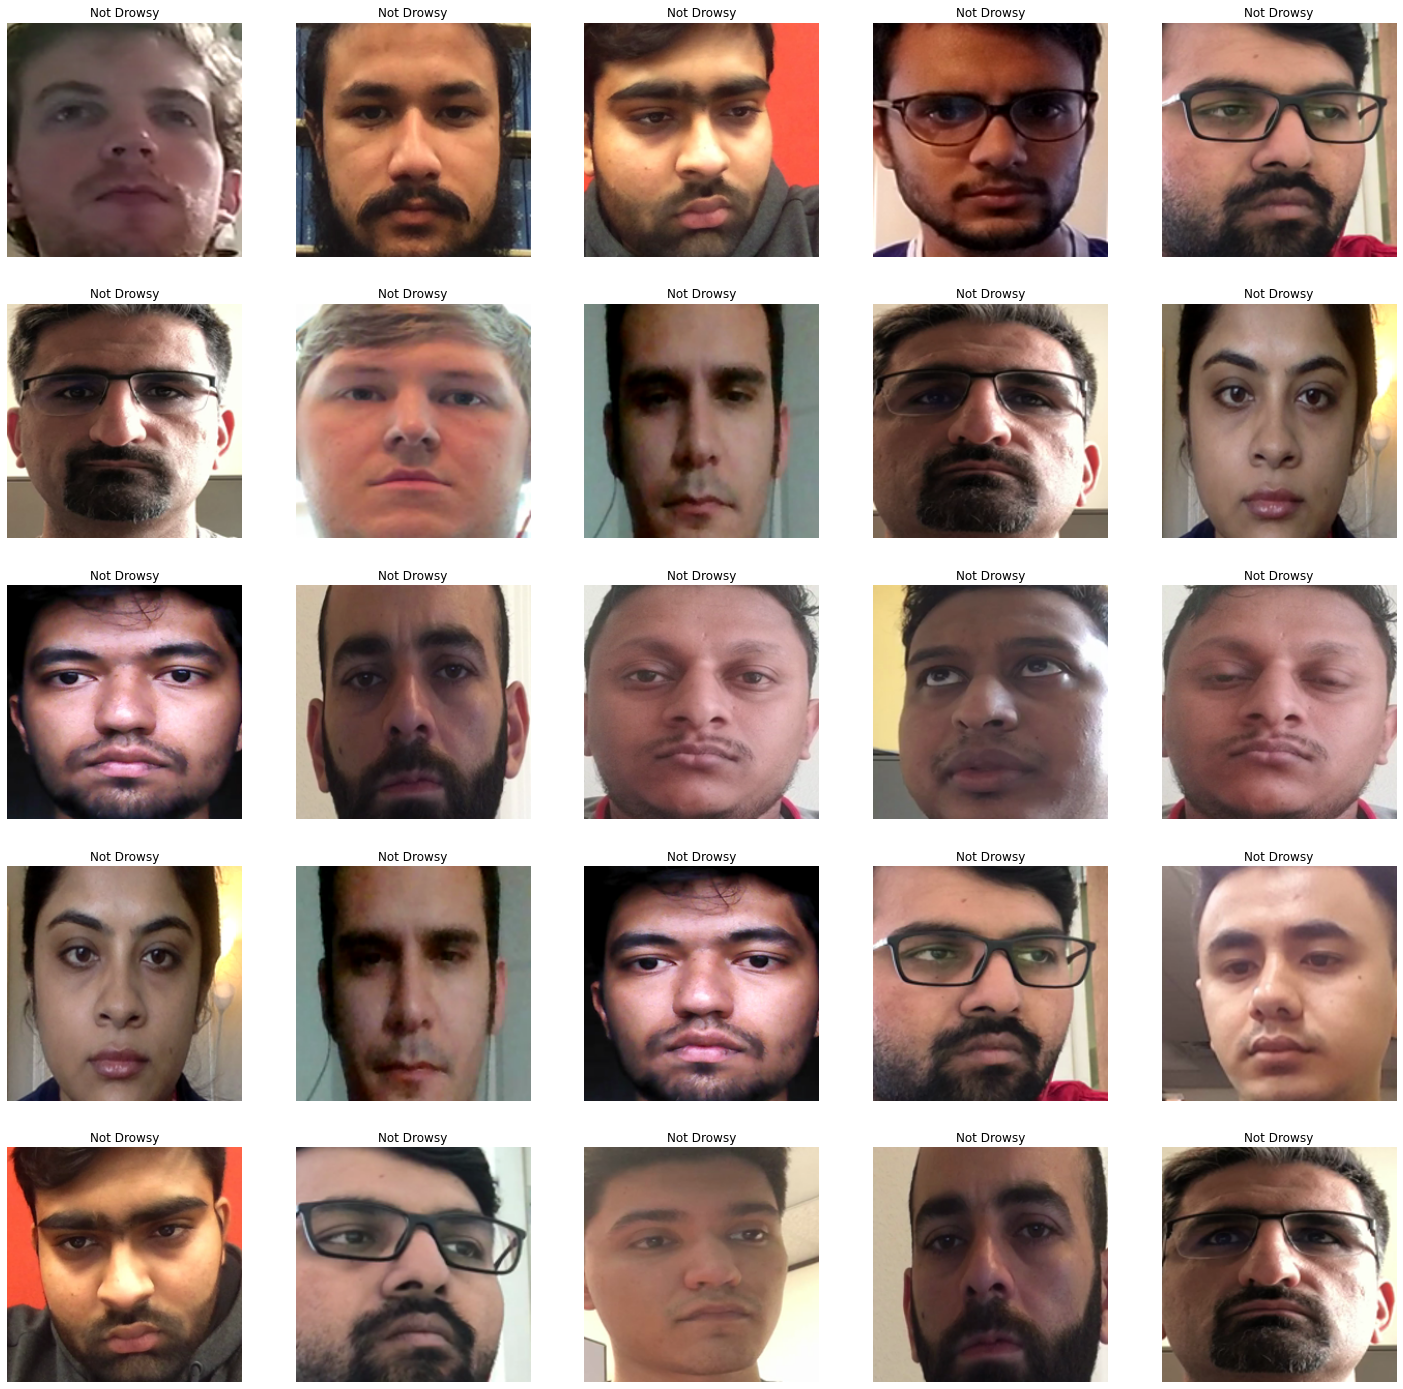

In [9]:
plt.figure(figsize=(25,25))
#temp = df[df['label']==1]['images']   
temp = df.loc[df['label']==1,'images']  #assign all NOT DROWSY image paths to a temp variable
start = random.randint(0, len(temp))
files = temp[start:start+25]  #selection of 25 random images for plotting

for index, file in enumerate(files):
  plt.subplot(5,5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title("Not Drowsy")
  plt.axis('off')

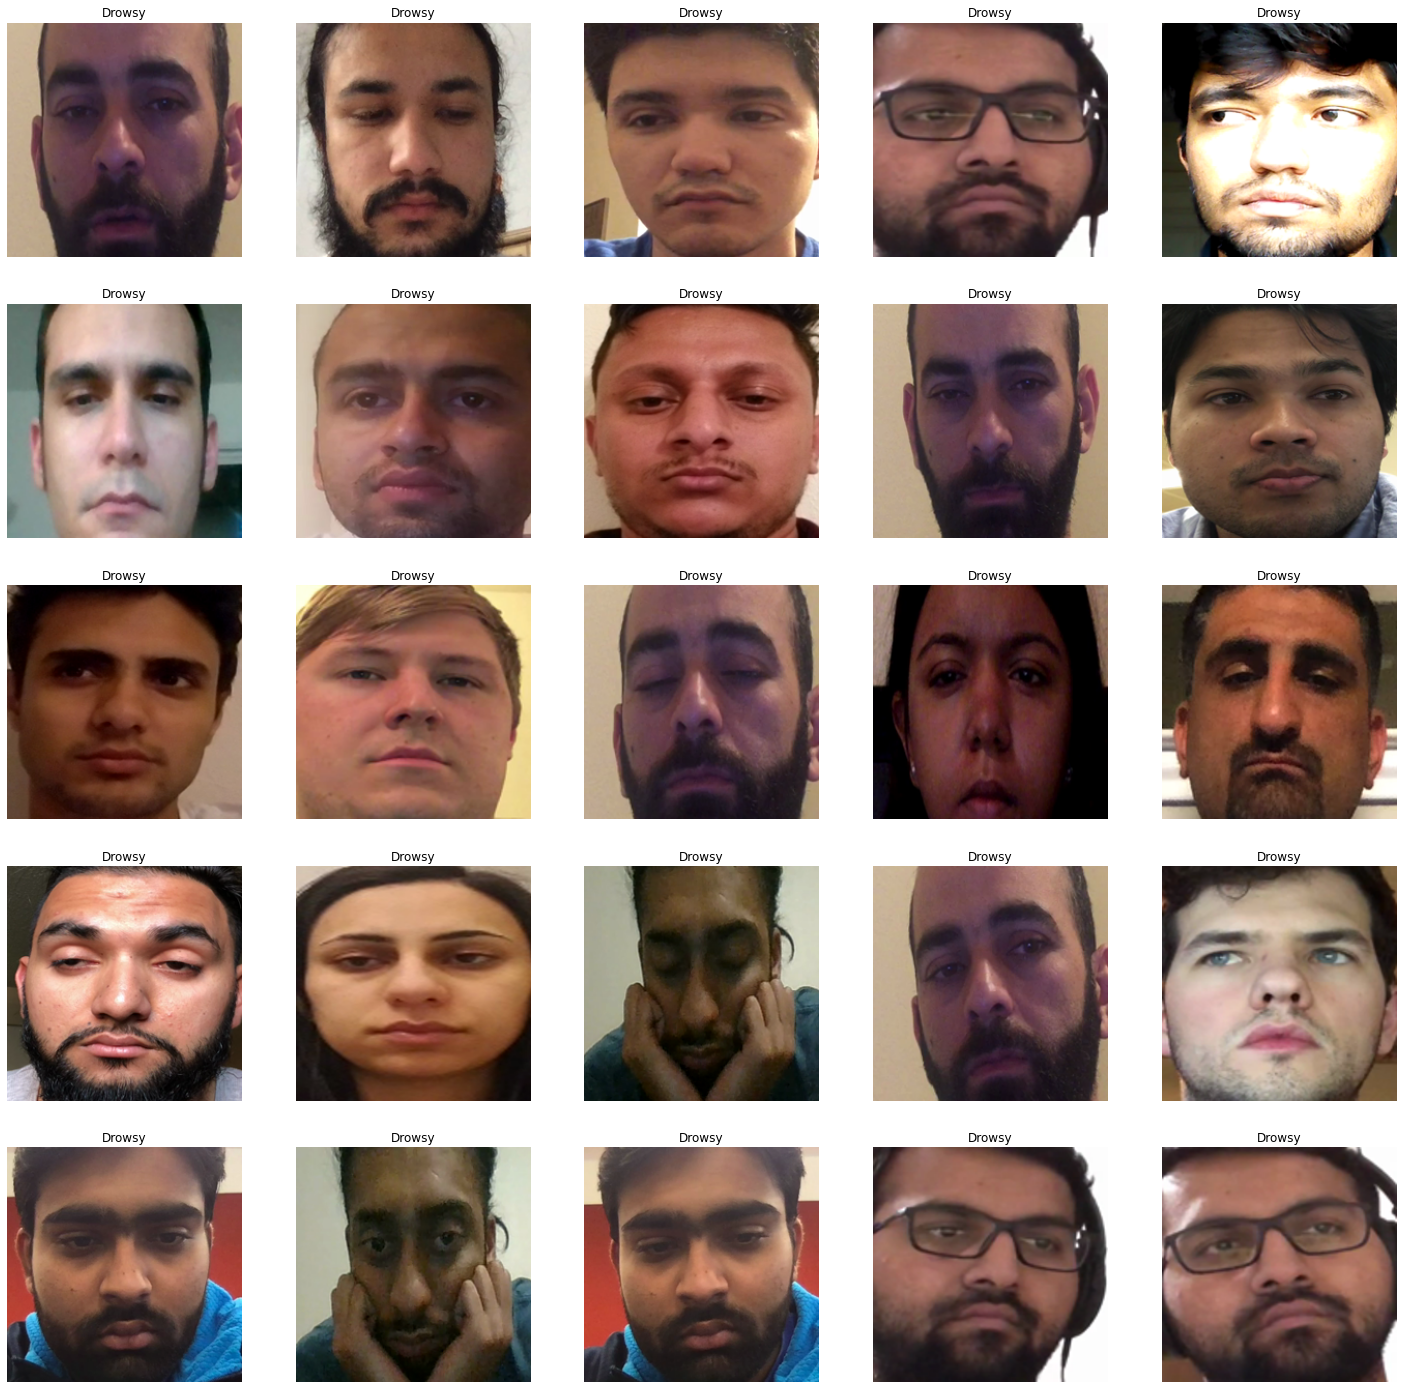

In [10]:
plt.figure(figsize=(25,25))
temp = df.loc[df['label']==0,'images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
  plt.subplot(5,5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title("Drowsy")
  plt.axis('off')

In [11]:
df['label'] = df['label'].astype('str')

In [12]:
# input split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=1234)

In [13]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255, # normalization of images
    rotation_range = 40, # augmentation of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
)

val_generator = ImageDataGenerator(rescale = 1./255)

In [14]:
train_iterator = train_generator.flow_from_dataframe(
    train, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

Found 33434 validated image filenames belonging to 2 classes.
Found 8359 validated image filenames belonging to 2 classes.


# Model Creation

In [15]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [16]:
model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
                    MaxPool2D((2,2)),
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(1, activation='sigmoid')
])

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [18]:
history = model.fit(train_iterator, epochs=10, validation_data=val_iterator)

Epoch 1/10
66/66 [==============================] - 252s 4s/step - loss: 0.6331 - accuracy: 0.6451 - val_loss: 0.4073 - val_accuracy: 0.8475
Epoch 2/10
66/66 [==============================] - 218s 3s/step - loss: 0.3731 - accuracy: 0.8444 - val_loss: 0.2112 - val_accuracy: 0.9091
Epoch 3/10
66/66 [==============================] - 212s 3s/step - loss: 0.1920 - accuracy: 0.9268 - val_loss: 0.0720 - val_accuracy: 0.9840
Epoch 4/10
66/66 [==============================] - 213s 3s/step - loss: 0.0958 - accuracy: 0.9681 - val_loss: 0.0330 - val_accuracy: 0.9917
Epoch 5/10
66/66 [==============================] - 212s 3s/step - loss: 0.0594 - accuracy: 0.9821 - val_loss: 0.0381 - val_accuracy: 0.9895
Epoch 6/10
66/66 [==============================] - 213s 3s/step - loss: 0.0386 - accuracy: 0.9881 - val_loss: 0.0400 - val_accuracy: 0.9895
Epoch 7/10
66/66 [==============================] - 213s 3s/step - loss: 0.0317 - accuracy: 0.9911 - val_loss: 0.0284 - val_accuracy: 0.9927
Epoch 8/10
66

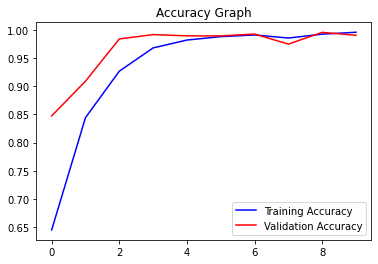

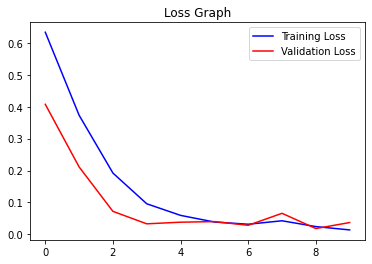

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))


plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [42]:
from PIL import Image
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image.show()
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (128, 128, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [43]:
image = load('Drowsy_2.jpg')
model.predict(image)

1/1 [==============================] - 0s 24ms/step


array([[0.99940443]], dtype=float32)

In [40]:
image = load('Drowsy_1_1.jpg')
model.predict(image)

1/1 [==============================] - 0s 33ms/step


array([[8.471921e-05]], dtype=float32)

In [41]:
image = load('Not_Drowsy.jpg')
model.predict(image)

1/1 [==============================] - 0s 21ms/step


array([[0.9988273]], dtype=float32)